### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

This fitting uses a Photonic Quantum Neural network.

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://pennylane.ai/
>
> https://pennylane.ai/qml/demos/quantum_neural_net.html

In [1]:
#pip3 install pennylane pennylane-sf pennylane-lightning

In [2]:
#pip3 install pennylane pennylane-sf pennylane-lightning pennylane-qiskit 

In [3]:
import pennylane as pnl
pnl.__version__

'0.25.0'

In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import r2_score

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [5]:
fano_data = pd.read_csv("../datasets/signal_080_peak_1_fano_adjust.csv")

In [6]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [7]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

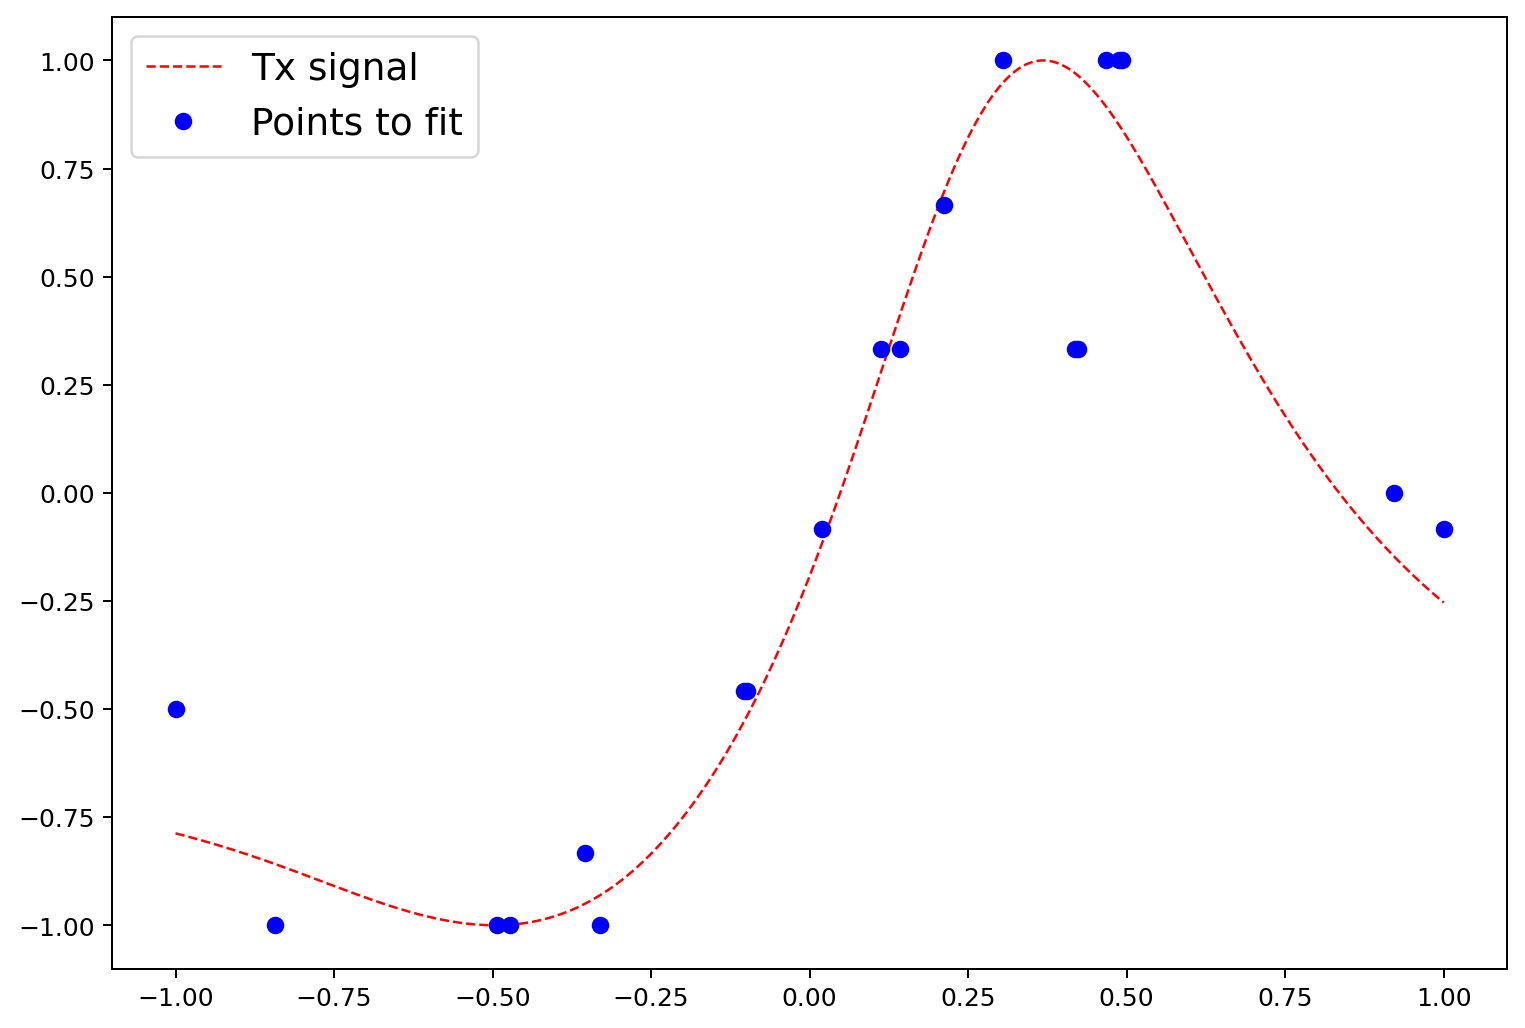

In [8]:
num_samples = 50
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = np.array(sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False)))
#print(indices)

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X, -1, 1)
y = scale(y, -1, 1)

X_ = scale(X_, -1, 1)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [9]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

In [10]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

In [11]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_neural_net(var, x):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

In [12]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [13]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

In [14]:
np.random.seed(0)
num_layers = 4
var_init = 0.08 * np.random.randn(num_layers, 5, requires_grad=True)

print(var_init)

[[ 0.14112419  0.03201258  0.07829904  0.17927146  0.14940464]
 [-0.07818223  0.07600707 -0.01210858 -0.00825751  0.03284788]
 [ 0.01152349  0.11634188  0.06088302  0.009734    0.03550906]
 [ 0.02669395  0.11952633 -0.01641266  0.02504542 -0.06832766]]


In [15]:
X_data = np.array(X.numpy()[:, 0], requires_grad=False)
y_data = np.array(y.numpy()[:, 0], requires_grad=False)

In [16]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

cost_plot = []

var = var_init
for it in range(500):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X_data, y_data)
    cost_plot.append(_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.4733931 
Iter:     1 | Cost: 0.4935457 
Iter:     2 | Cost: 0.4834823 
Iter:     3 | Cost: 0.5170693 
Iter:     4 | Cost: 0.5918725 
Iter:     5 | Cost: 0.5481904 
Iter:     6 | Cost: 0.6261624 
Iter:     7 | Cost: 0.5687947 
Iter:     8 | Cost: 0.5694853 
Iter:     9 | Cost: 0.5198560 
Iter:    10 | Cost: 0.5471120 
Iter:    11 | Cost: 0.5817758 
Iter:    12 | Cost: 0.5520643 
Iter:    13 | Cost: 0.6220906 
Iter:    14 | Cost: 0.5805287 
Iter:    15 | Cost: 0.5232667 
Iter:    16 | Cost: 0.5823618 
Iter:    17 | Cost: 0.5925773 
Iter:    18 | Cost: 0.5656568 
Iter:    19 | Cost: 0.6058041 
Iter:    20 | Cost: 0.6010776 
Iter:    21 | Cost: 0.6779794 
Iter:    22 | Cost: 0.6582431 
Iter:    23 | Cost: 0.6601176 
Iter:    24 | Cost: 0.7828345 
Iter:    25 | Cost: 0.6891542 
Iter:    26 | Cost: 0.6939141 
Iter:    27 | Cost: 0.6375190 
Iter:    28 | Cost: 0.6106046 
Iter:    29 | Cost: 0.5986132 
Iter:    30 | Cost: 0.6368994 
Iter:    31 | Cost: 0.6575806 
Iter:   

Iter:   265 | Cost: 0.5054334 
Iter:   266 | Cost: 0.5359680 
Iter:   267 | Cost: 0.5192962 
Iter:   268 | Cost: 0.5671281 
Iter:   269 | Cost: 0.5988381 
Iter:   270 | Cost: 0.5232012 
Iter:   271 | Cost: 0.5424253 
Iter:   272 | Cost: 0.5630423 
Iter:   273 | Cost: 0.5563221 
Iter:   274 | Cost: 0.5829191 
Iter:   275 | Cost: 0.5700725 
Iter:   276 | Cost: 0.5494533 
Iter:   277 | Cost: 0.5555001 
Iter:   278 | Cost: 0.5202063 
Iter:   279 | Cost: 0.5365562 
Iter:   280 | Cost: 0.5058804 
Iter:   281 | Cost: 0.5416460 
Iter:   282 | Cost: 0.5234657 
Iter:   283 | Cost: 0.5205643 
Iter:   284 | Cost: 0.5654723 
Iter:   285 | Cost: 0.5023285 
Iter:   286 | Cost: 0.5392809 
Iter:   287 | Cost: 0.5510357 
Iter:   288 | Cost: 0.5381578 
Iter:   289 | Cost: 0.5399748 
Iter:   290 | Cost: 0.5510454 
Iter:   291 | Cost: 0.5611198 
Iter:   292 | Cost: 0.5536764 
Iter:   293 | Cost: 0.5391283 
Iter:   294 | Cost: 0.5368519 
Iter:   295 | Cost: 0.5367165 
Iter:   296 | Cost: 0.5532939 
Iter:   

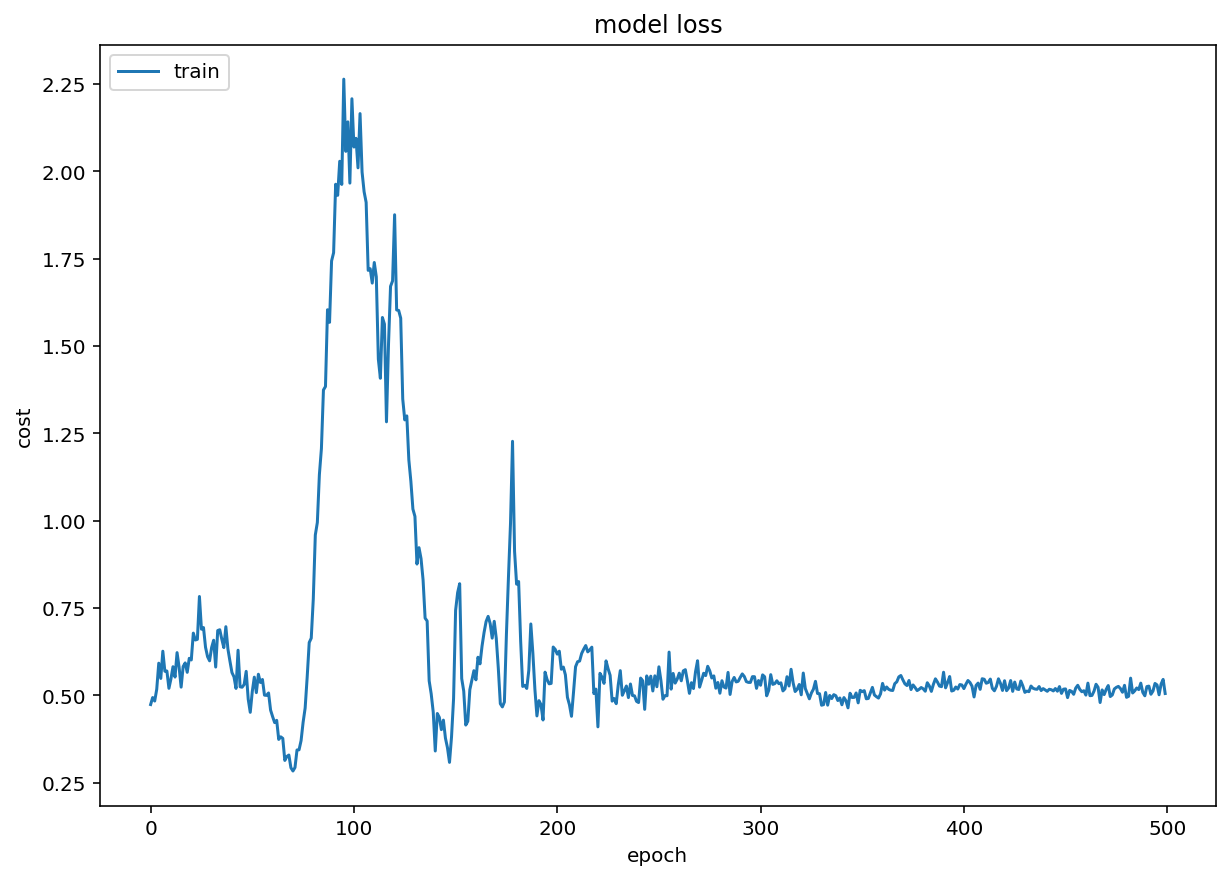

In [26]:
# summarize history for loss
plt.plot(cost_plot)
plt.title('model loss')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [18]:
X_pred = X_.numpy()[:,0]

In [20]:
y_predict = [quantum_neural_net(var, x_) for x_ in X_pred]

In [22]:
y_predict_smooth = smooth(y_predict)

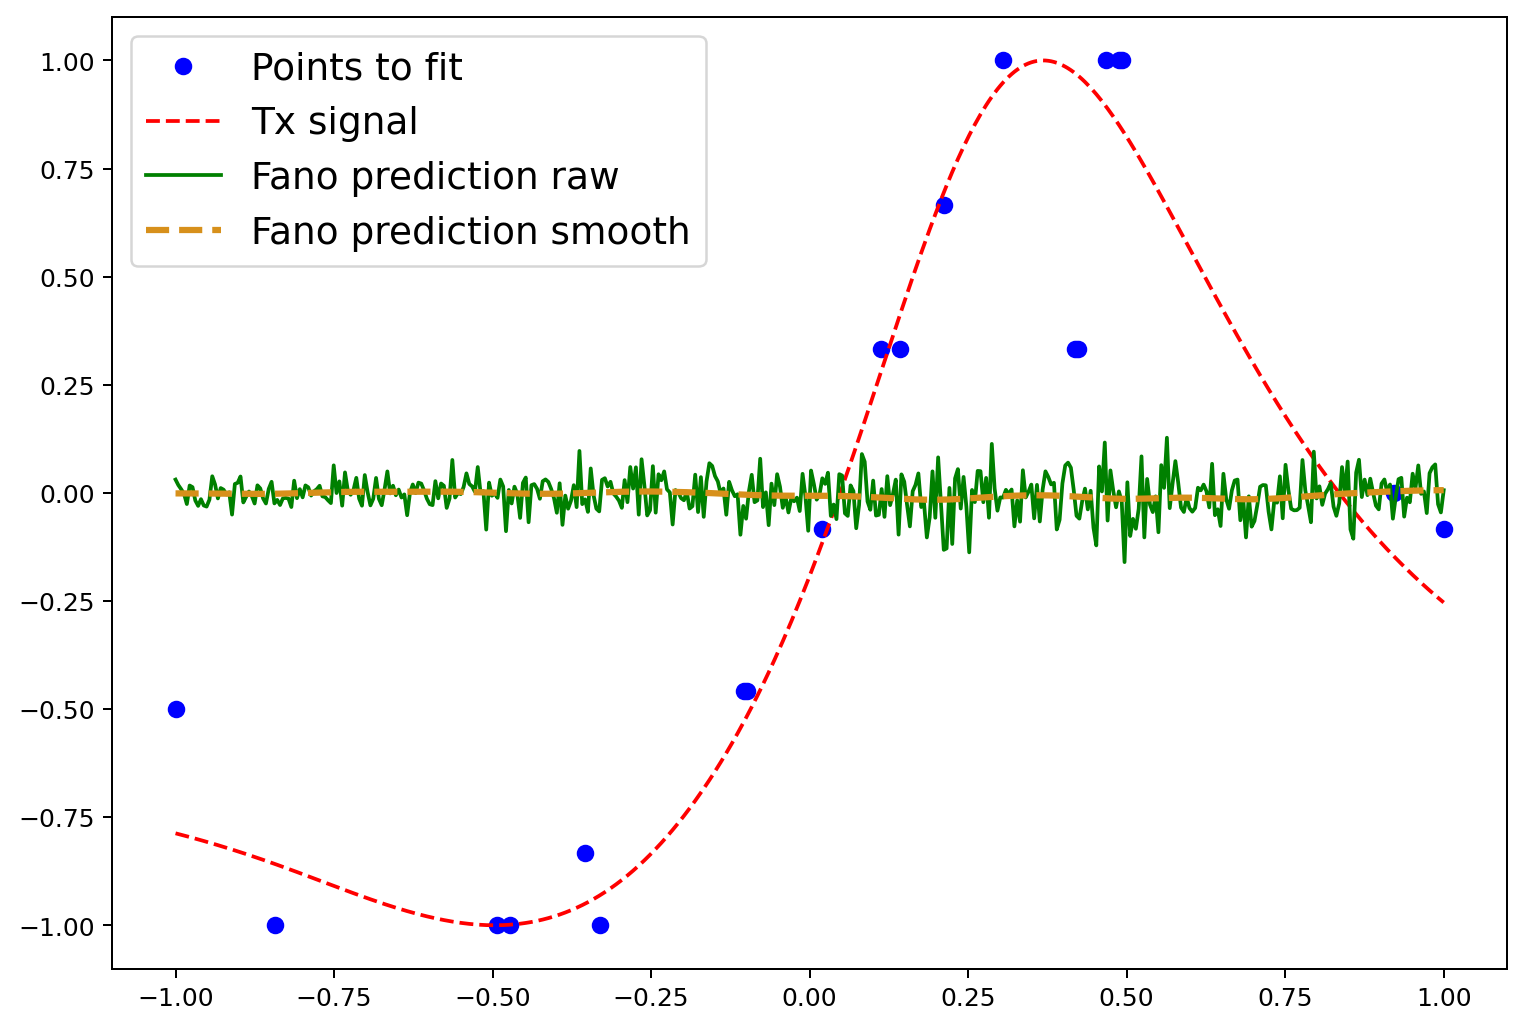

In [23]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict, "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth, "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

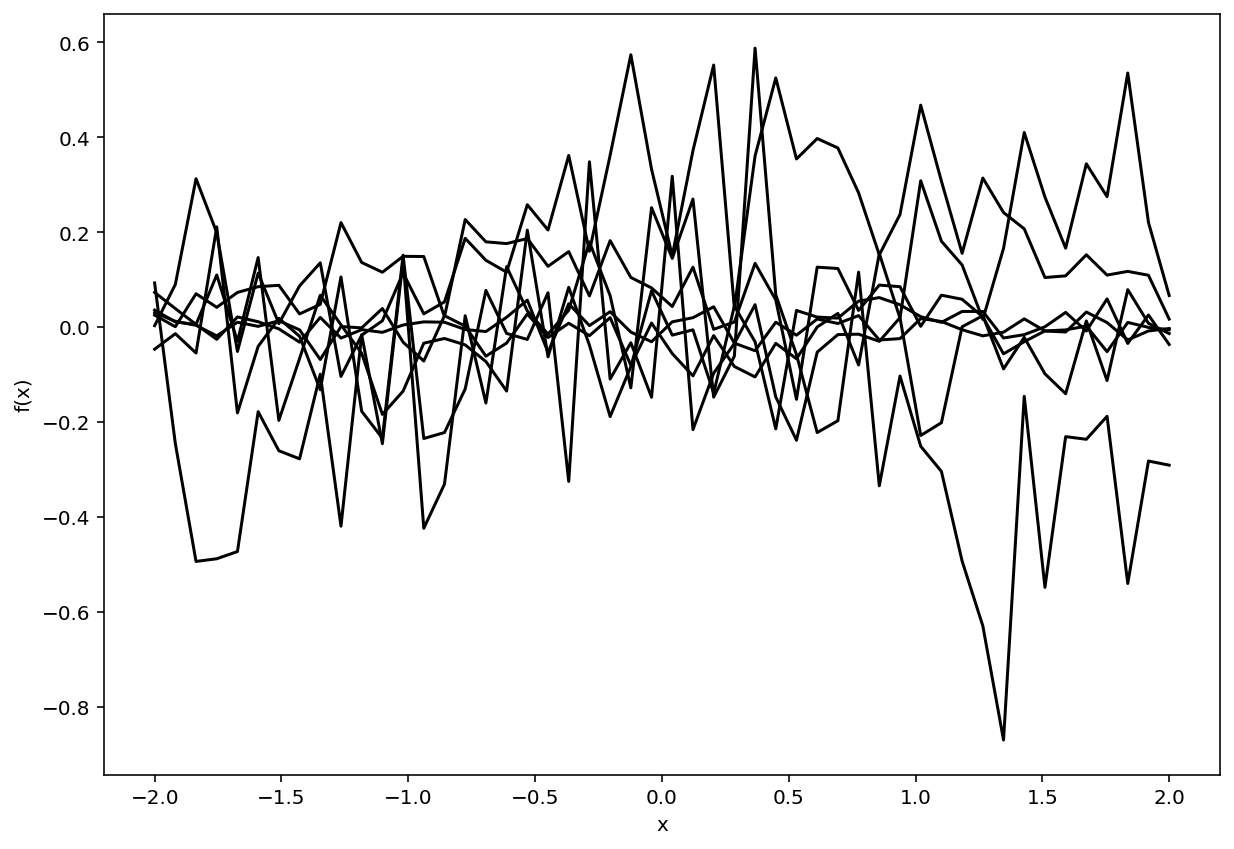

In [24]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

In [25]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright